In [1]:
import pandas as pd
import numpy as np
from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree
# from pct.tree.ftest.ftest import FTest


## From YXH's data process

In [2]:

from sklearn.preprocessing import LabelEncoder

# Load the u.data dataset
u_data = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

# # # Perform label encoding on user_id and item_id
# user_encoder = LabelEncoder()
# item_encoder = LabelEncoder()

# u_data['user_id'] = user_encoder.fit_transform(u_data['user_id'])
# u_data['item_id'] = item_encoder.fit_transform(u_data['item_id'])

# # # Create the rating matrix
# n_users = u_data['user_id'].nunique()
# n_items = u_data['item_id'].nunique()

# Define the threshold
THRESHOLD = 3  # Ratings above this are "Lovers", below are "Haters"

# Pivot the data
rating_matrix = u_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
rating_matrix.index = u_data['user_id'].unique()  # Ensure user_id alignment
rating_matrix.columns = u_data['item_id'].unique()  # Ensure item_id alignment


# Apply threshold classification to the rating matrix (after thresholding)
rating_matrix_thresholded = np.where(rating_matrix > THRESHOLD, 1, np.where(rating_matrix > 0, -1, 0))

# Convert numpy array to pandas DataFrame for easier inspection
rating_matrix_thresholded_df = pd.DataFrame(rating_matrix_thresholded)


In [ ]:
u_data

In [3]:
rating_matrix

,242,302,377,51,346,474,265,465,451,86,...,1594,1626,1645,1659,1682,1674,1640,1637,1630,1641
196,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## initiate tree and splitter

In [4]:
tree = Tree(min_instances=7)
tree.fit(rating_matrix, u_data['rating'], target_weights=None)




✅ Converted x and y to DataFrame
✅ Assigned x and y
✅ Creating target weights...
✅ Identifying numerical and categorical attributes...
✅ Creating Splitter...
Initializing Splitter...
✅ Calling build()...
🌲 Building predictive clustering tree...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔍 Best item for splitting:  581
Type of x: <class 'pandas.core.frame.DataFrame'>
👥 Users who rated item 581: 1
❤️ Lovers: 1
💔 Haters: 0
❓ Unknowns: 942
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
🌲 Building predictive clustering tree...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:62: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔍 Best item for splitting:  581
Type of x: <class 'pandas.core.frame.DataFrame'>
👥 Users who rated item 581: 0
❤️ Lovers: 0
💔 Haters: 0
❓ Unknowns: 942
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
🌲 Building predictive clustering tree...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:62: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  581
Type of x: <class 'pandas.core.frame.DataFrame'>
👥 Users who rated item 581: 0
❤️ Lovers: 0
💔 Haters: 0
❓ Unknowns: 942
🔄 Recursively building tree for subsets...
🍃 Reached max depth at node <pct.tree.node.node.Node object at 0x7fe55f89deb0>. Stopping recursion.
🍃 Reached max depth at node <pct.tree.node.node.Node object at 0x7fe55f89deb0>. Stopping recursion.
🍃 Reached max depth at node <pct.tree.node.node.Node object at 0x7fe55f89deb0>. Stopping recursion.
✅ Tree built successfully!


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:62: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


In [4]:
tree.print_tree_structure()

Node: 580_1
Attribute: 580
Criterion: [0.]
Leaf Node: No
Children:
    Node: leaf_2=[4.] (1.0)
    Attribute: None
    Criterion: None
    Leaf Node: No
    Children:
        Node: 580_1
        Attribute: 580
        Criterion: [0.]
        Leaf Node: No
        Children:
        Node: 580_1
        Attribute: 580
        Criterion: [0.]
        Leaf Node: No
        Children:
        Node: 580_1
        Attribute: 580
        Criterion: [0.]
        Leaf Node: No
        Children:
    Node: leaf_3=[nan] (0.0)
    Attribute: None
    Criterion: None
    Leaf Node: No
    Children:
        Node: 580_1
        Attribute: 580
        Criterion: [0.]
        Leaf Node: No
        Children:
        Node: 580_1
        Attribute: 580
        Criterion: [0.]
        Leaf Node: No
        Children:
        Node: 580_1
        Attribute: 580
        Criterion: [0.]
        Leaf Node: No
        Children:
    Node: 580_4
    Attribute: 580
    Criterion: [0.]
    Leaf Node: No
    Children:
   

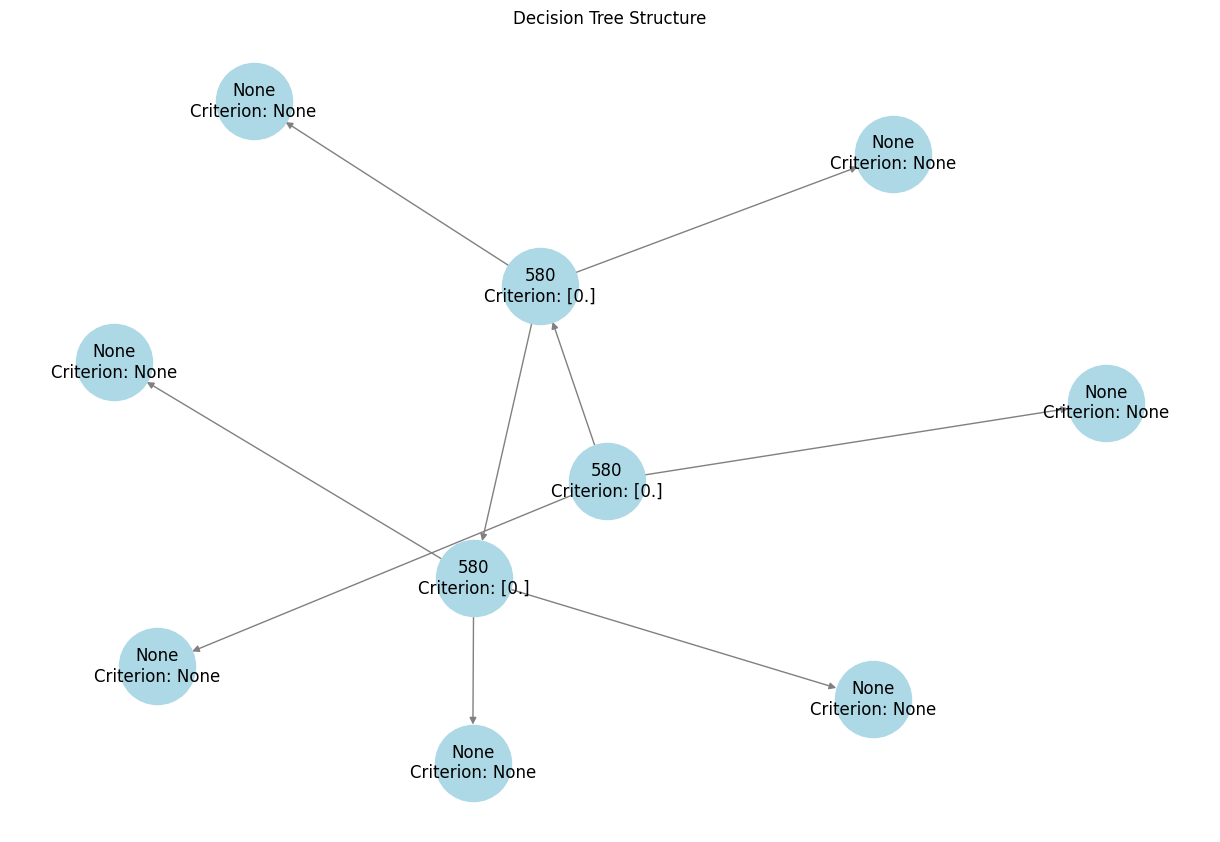

In [4]:
tree.visualize_tree()


## create rI and rU during preprocessing phase

In [ ]:

# Create rI and rU indexes for training set (R)
# rI: item to user ratings (dictionary of items with lists of user ratings)
rI = {}
for _, row in u_data.iterrows():
    item_id = row['item_id']
    user_id = row['user_id']
    rating = row['rating']
    if item_id not in rI:
        rI[item_id] = []
    rI[item_id].append((user_id, rating))

# rU: user to item ratings (dictionary of users with lists of item ratings)
rU = {}
for _, row in u_data.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    rating = row['rating']
    if user_id not in rU:
        rU[user_id] = []
    rU[user_id].append((item_id, rating))

In [ ]:
# Optionally, print rI and rU to check the data structure for training and testing
print("\nSample rI (item to user ratings) for Training Set:")
for item in list(rI.keys())[:2]:  # Display sample item indices
    print(f"Item {item}: {rI[item]}")

print("\nSample rU (user to item ratings) for Training Set:")
for user in list(rU.keys())[:2]:  # Display sample user indices
    print(f"User {user}: {rU[user]}")

In [ ]:
# find and count users who have rated item 246 and their ratings
item_id = 55
print(f"Users who have rated item {item_id} and their ratings:")
print(rI[item_id])

# count users who have rated item 246 and their ratings
print(f"Number of users who have rated item {item_id}: {len(rI[item_id])}")

In [ ]:

print(f"Number of users who didn't rate item {item_id}:")
print(n_users - len(rI[item_id]))